# Tiny example for Flux.jl

This example is slightly a slightly adapted version of the [tutorial example by Flux.jl](https://fluxml.ai/Flux.jl/stable/models/quickstart/). The underlying problem for the XOR function goes back to the book by Minsky 1969 [see also](https://en.wikipedia.org/wiki/Perceptrons_(book))

The original example runs on GPU, but here we'll run on CPU. 

In [1]:
# Packages
using Pkg
Pkg.activate(".")
using Flux
using Plots
using Statistics
using ProgressMeter

  Activating project at `~/src_nobackup/julia_ml_tests.jl.git`


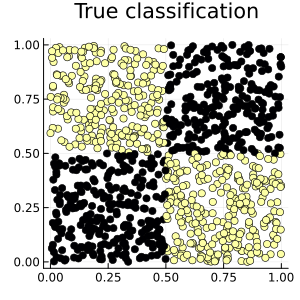

In [2]:
# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
# Note that Flux expects Float32 arrays by default
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}

scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false, size=(300,300))

In [3]:
# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax)         

Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 604 bytes.

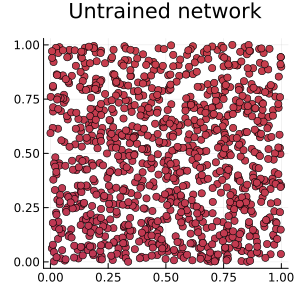

In [4]:
# Run the untrained model
# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy)                               # 2×1000 Matrix{Float32}

scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1), legend=false, size=(300,300))
# The output is some smooth random function of the input.

In [5]:
# Train the model

# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target), batchsize=64, shuffle=true);
# DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix); it cuts the data in pieces

optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

optim # parameters, momenta and output have all changed
out2 = model(noisy)  # first row is prob. of true, second row p(false)


Progress:   0%|▏                                        |  ETA: 2:29:57

Progress:  45%|██████████████████▌                      |  ETA: 0:00:23

Progress:  51%|████████████████████▉                    |  ETA: 0:00:19

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:15

Progress:  60%|████████████████████████▊                |  ETA: 0:00:13

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:10

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:08

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:07

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:05

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:03

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


2×1000 Matrix{Float32}:
 0.00765605  0.99713     3.03985f-5  …  0.0226868  0.0959574  0.999925
 0.992344    0.00287018  0.99997        0.977313   0.904043   7.45914f-5

Accuracy of the trained model on the training set: 0.968


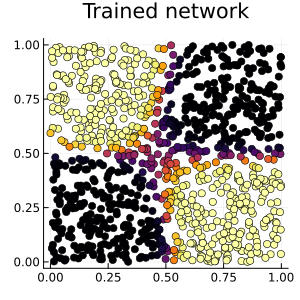

In [6]:
# Evaluate the trained model (on the training set for now / a bad practice) 
acc_trained = mean((out2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!
println("Accuracy of the trained model on the training set: ", acc_trained)

scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false, size=(300,300))


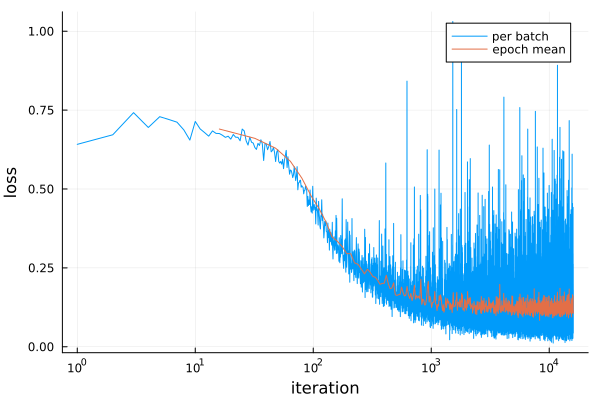

In [7]:
# Plot changes to the cost function as the model trains

plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean",)